![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest parameter optimization
</b>
</span>

---
**Notebook version**: `1` (25 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch) 

</br>

# **Background**

- Finding optimal model parameters

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import importlib.metadata
from datetime import datetime
from diive.configs.exampledata import load_exampledata_parquet
from diive.pkgs.gapfilling.randomforest_ts import OptimizeParamsRFTS
import matplotlib.pyplot as plt
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.77.0


</br>

# **Docstring** for `RandomForestTS`

In [3]:
help(OptimizeParamsRFTS)

Help on class OptimizeParamsRFTS in module diive.pkgs.gapfilling.randomforest_ts:

class OptimizeParamsRFTS(builtins.object)
 |  OptimizeParamsRFTS(df: pandas.core.frame.DataFrame, target_col: str, **rf_params: dict)
 |  
 |  Optimize parameters for random forest model
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: pandas.core.frame.DataFrame, target_col: str, **rf_params: dict)
 |      Args:
 |          df: dataframe of target and predictor time series
 |          target_col: name of target in *df*, all variables that are not *target* are
 |              used as predictors
 |          **rf_params: dict of parameters for random forest model, where parameter ranges are
 |              provided as lists, e.g.
 |                  rf_params = {
 |                      'n_estimators': list(range(2, 12, 2)),
 |                      'criterion': ['squared_error'],
 |                      'max_depth': [None],
 |                      'min_samples_split': list(range(2, 12, 2)),
 |   

</br>

# **Load data**

## Load example data from parquet file

In [4]:
df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.051 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
subset = df[subsetcols].copy()
_subset = df.index.year >= 2020
subset = subset[_subset].copy()
subset

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
TIMESTAMP_MIDDLE,,,,
2020-01-01 00:15:00,NaN,-0.610,2.101,0.0
2020-01-01 00:45:00,NaN,-0.403,2.262,0.0
2020-01-01 01:15:00,NaN,-0.517,2.216,0.0
2020-01-01 01:45:00,0.009,-0.460,2.269,0.0
2020-01-01 02:15:00,NaN,-0.607,2.198,0.0
...,...,...,...,...
2022-12-31 21:45:00,NaN,3.463,2.210,0.0
2022-12-31 22:15:00,3.518,5.283,3.327,0.0
2022-12-31 22:45:00,NaN,5.537,3.467,0.0


In [6]:
subset.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,17854.000000,52608.000000,52608.000000,52608.000000
mean,-3.168904,4.906338,3.180231,158.514053
std,5.642207,7.462950,3.722807,255.365855
min,-27.522000,-15.897000,0.000000,0.000000
25%,-6.869750,-0.623000,0.517000,0.000000
50%,-2.700000,4.730000,1.981000,4.078500
75%,0.785750,10.277000,4.357000,234.918000
max,20.974000,26.587000,27.903000,1197.800000


In [7]:
sstats(subset[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2020-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,1095 days 23:30:00
NOV,17854
MISSING,34754
MISSING_PERC,66.062196
MEAN,-3.168904
MEDIAN,-2.7
SD,5.642207
VAR,31.834502


F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


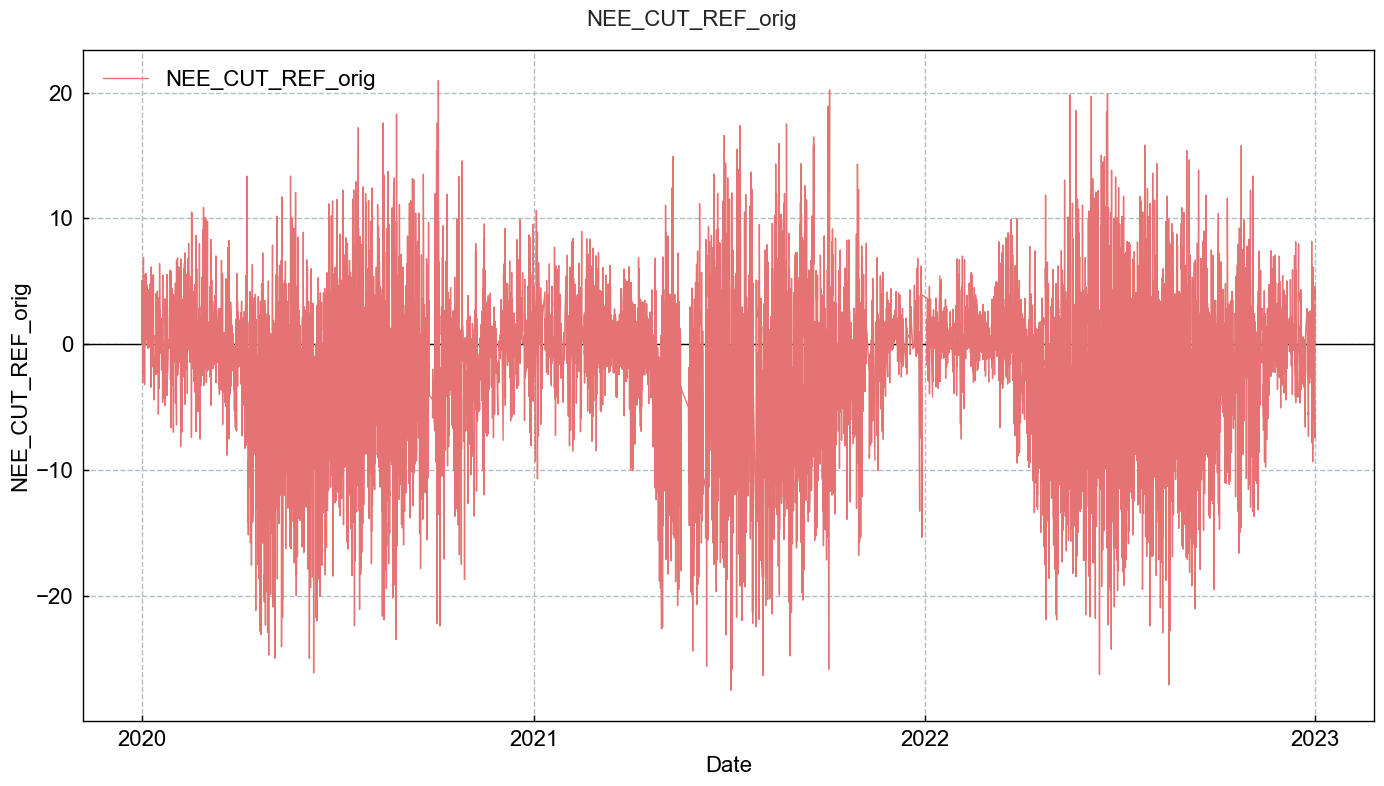

In [8]:
# TimeSeries(series=subset[TARGET_COL]).plot_interactive()
TimeSeries(series=subset[TARGET_COL]).plot()

</br>

</br>

# **Parameter optimization**

## Initialize

In [24]:
# Random forest parameters
rf_params = {
    'n_estimators': [10, 20],
    # 'n_estimators': list(range(3, 33, 3)),
    'criterion': ['squared_error'],
    # 'max_depth': list(range(1, 35, 1)),
    'max_depth': [6, 12],    # Can also be None
    'min_samples_split': [10, 40],
    # 'min_samples_split': list(range(2, 12, 2)),
    'min_samples_leaf': [5, 20],
    # 'min_samples_leaf': list(range(2, 12, 2))
}

# Optimization
opt = OptimizeParamsRFTS(
    df=subset,
    target_col=TARGET_COL,
    **rf_params
)

</br>

## Optimize parameters

In [25]:
%%time
opt.optimize()

CPU times: total: 1.28 s
Wall time: 7.76 s


</br>

## Result

In [26]:
print("Estimator which gave highest score (or smallest loss if specified) on the left out data:")
display(opt.best_params)
print("\nModel scores for best model:")
display(opt.scores)
print(f"\nMean cross-validated score of the best_estimator: {opt.best_score}")
print(f"\nThe number of cross-validation splits (folds/iterations): {opt.cv_n_splits}")

Estimator which gave highest score (or smallest loss if specified) on the left out data:


{'criterion': 'squared_error',
 'max_depth': 12,
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'n_estimators': 20}


Model scores for best model:


{'mae': 2.5691211988107443,
 'medae': 1.8383153132403613,
 'mse': 13.0489757061107,
 'rmse': 3.6123365992264205,
 'mape': 1.7435439306788323,
 'maxe': 23.0796219745313,
 'r2': 0.6058378807381681}


Mean cross-validated score of the best_estimator: -12.420701944007751

The number of cross-validation splits (folds/iterations): 10


In [27]:
# Cross-validation results
opt.cv_results.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,...,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
13,0.705710,0.359971,0.003690,0.000639,squared_error,12,...,-10.925761,-11.926896,-14.466808,-12.420702,1.094537,1
15,0.632606,0.330953,0.003690,0.000639,squared_error,12,...,-11.005290,-11.955632,-14.423970,-12.453454,1.052715,2
11,0.817711,0.430292,0.004090,0.000299,squared_error,12,...,-10.960814,-11.983250,-14.432534,-12.479323,1.091552,3
10,0.419277,0.226804,0.002494,0.000499,squared_error,12,...,-11.341938,-12.049018,-14.419392,-12.502847,1.002351,4
12,0.428055,0.291541,0.002591,0.000491,squared_error,12,...,-10.972254,-12.236968,-14.648845,-12.584632,1.124805,5
14,0.377290,0.186932,0.002394,0.000489,squared_error,12,...,-11.144974,-12.172346,-14.662964,-12.606999,1.150170,6
9,1.058366,0.580524,0.006782,0.006225,squared_error,12,...,-11.148723,-11.991647,-14.645555,-12.637217,1.038823,7
1,0.623131,0.325603,0.003491,0.000669,squared_error,6,...,-11.601504,-12.507369,-15.150866,-12.794602,1.063946,8
7,0.547933,0.274804,0.003391,0.000489,squared_error,6,...,-11.555001,-12.617391,-15.028955,-12.819180,1.062942,9
8,0.480713,0.227634,0.002892,0.000299,squared_error,12,...,-11.176391,-12.310684,-14.670053,-12.821945,1.048912,10


In [28]:
r = opt.cv_results.sort_values(by="rank_test_score").loc[:, "params"]
# [print(rr) for rr in r]
print(*[i for i in r], sep="\n")

{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 20}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 20}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 40, 'n_estimators': 20}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 40, 'n_estimators': 10}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 10}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}
{'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}
{'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 20

</br>

## Plot

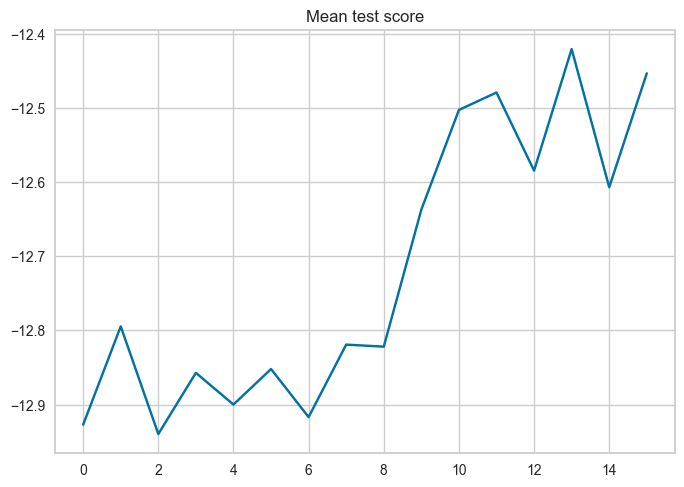

In [29]:
opt.cv_results['mean_test_score'].plot(title="Mean test score");

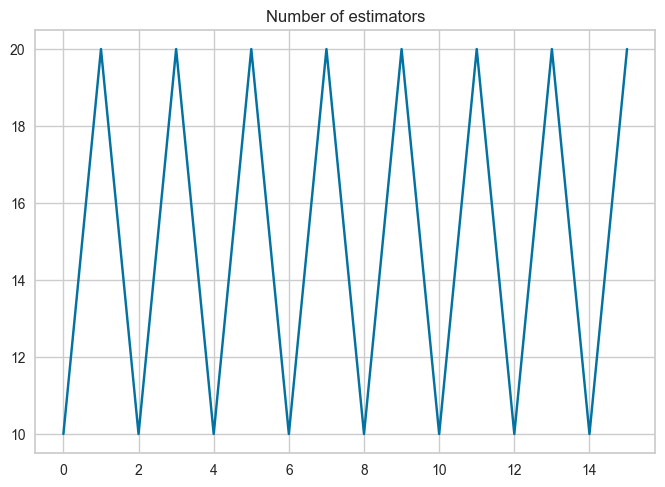

In [30]:
opt.cv_results['param_n_estimators'].plot(title="Number of estimators");

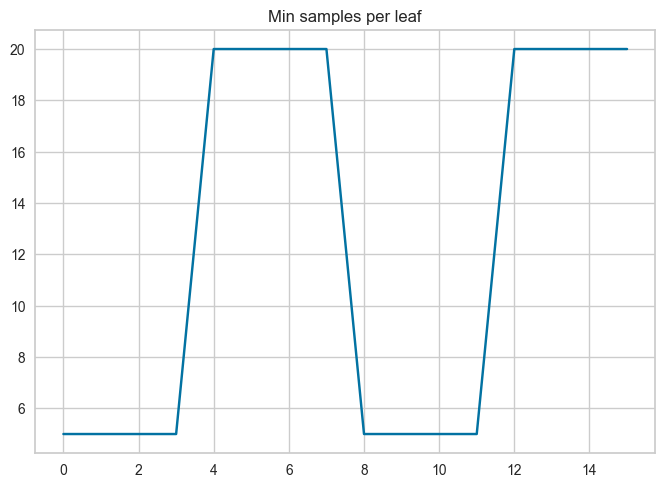

In [31]:
opt.cv_results['param_min_samples_leaf'].plot(title="Min samples per leaf");

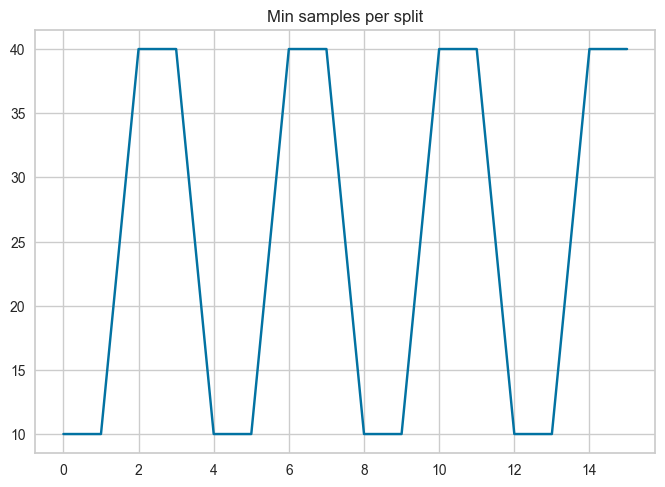

In [32]:
opt.cv_results['param_min_samples_split'].plot(title="Min samples per split");

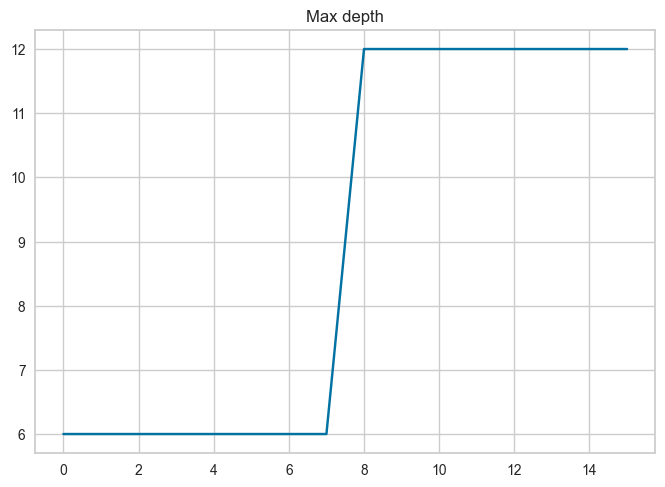

In [33]:
opt.cv_results['param_max_depth'].plot(title="Max depth");

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [34]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-06-11 15:47:15
